<a href="https://colab.research.google.com/github/K-N-H/Cherry-Blossom-Peak-Bloom/blob/main/PBD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yoshino Cherry Blossom Peak Bloom Date Exploratory Data Analysis
####Author: K.N.H.
####Date: April 6, 2025


##Introduction
The cherry blossom peak blooms in Washington D.C. is a highly anticipated annual event, drawing over a million visitors each year to witness the display. These blossoms have come to symbolize the arrival of spring, with their timing largely shaped by environmental factors. The peak bloom date (PBD) refers to the day in which 70% of Yoshino cherry blossoms are in full bloom. The purpose of this notebook is to analyze the relationship between pre-bloom temperatures and the PBD of Yoshino cherry blossoms, the dominant variety at the Tidal Basin.

Utilizing over 100 years of PBD data from the National Park Service (NPS) and temperature records from the National Weather Service, this exploratory data analysis (EDA) aims to identify trends in the timing of peak bloom and examine how variations in temperature might influence the timing of this iconic event.

**Research Question:** How do pre-bloom temperatures influence the timing of the peak bloom date of Yoshino cherry blossoms in Washington D.C.?

In [1]:
# import relevant libraries for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from statsmodels.robust.robust_linear_model import RLM

##Data Description

In [2]:
# upload PBD data (1921-2025)

df_PBD=pd.read_csv('PBD.csv', skiprows=6)
df_PBD = pd.concat([df_PBD, pd.DataFrame({'Year': [2025], 'Yoshino peak bloom date': [87]})], ignore_index=True)
df_PBD.drop(columns=['Cherry blossom festival start date', 'Cherry blossom festival duration'], inplace=True)
df_PBD.describe().astype(int)

,Year,Yoshino peak bloom date
count,105,105
mean,1973,93
std,30,7
min,1921,74
25%,1947,88
50%,1973,94
75%,1999,99
max,2025,108


The Yoshino Washington D.C. PBD has been recorded since 1921 in days of the year (DOY) format. The average PBD is the 93rd day of the year, which is April 3rd. The interquartile range (IQR) of the peak bloom dates falls between **March 29th** (88th day) and **April 9th** (99th day), meaning that 50% of the recorded peak bloom dates occur within this range. The earliest and latest PBD ever recorded was March 15th (74th day) and August 18th (108th day), respectively.

In [3]:
# PBD is expressed in DOY. Change format to month and day for readability

df_PBD['PBD']=pd.to_datetime(df_PBD['Year'].astype(str)+ '-' +df_PBD['Yoshino peak bloom date'].astype(str), format='%Y-%j')
df_PBD['month']=pd.to_datetime(df_PBD['PBD']).dt.month_name()
df_PBD['day']=pd.to_datetime(df_PBD['PBD']).dt.day
df_PBD.head()

,Year,Yoshino peak bloom date,PBD,month,day
0,1921,79,1921-03-20,March,20
1,1922,97,1922-04-07,April,7
2,1923,99,1923-04-09,April,9
3,1924,104,1924-04-13,April,13
4,1925,86,1925-03-27,March,27


In [4]:
# upload mean D.C. temperature per month from 1921-2025

df_temp=pd.read_csv('DC_monthly_temp.csv')
df_temp = df_temp.apply(pd.to_numeric, errors='coerce')
df_temp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1921,36.6,39.0,55.5,59.1,62.3,74.2,79.3,72.7,74.4,57.0,47.5,37.9,58.0
1,1922,31.9,38.7,45.3,55.6,66.9,74.5,76.6,73.1,69.9,59.4,47.9,37.6,56.5
2,1923,36.8,32.6,45.3,53.6,63.4,75.6,75.7,74.4,69.7,56.1,45.1,45.0,56.1
3,1924,35.0,34.3,42.6,51.9,60.0,71.3,75.0,74.8,64.3,57.5,46.0,36.5,54.1
4,1925,32.9,43.1,46.4,56.9,60.6,77.4,76.8,73.0,72.8,52.0,44.3,36.9,56.1


In [5]:
# upload daily temperature data for Washington D.C. from March and April from 2000-2025 to investigate more recent detailed trends

df_daily=pd.read_csv('daily_temp.csv')
df_daily[['date', 'max_temp', 'min_temp', 'avg_temp']].head()

,date,max_temp,min_temp,avg_temp
0,2000-03-01,64,40,52.0
1,2000-03-02,60,39,49.5
2,2000-03-03,54,35,44.5
3,2000-03-04,58,35,46.5
4,2000-03-05,67,41,54.0


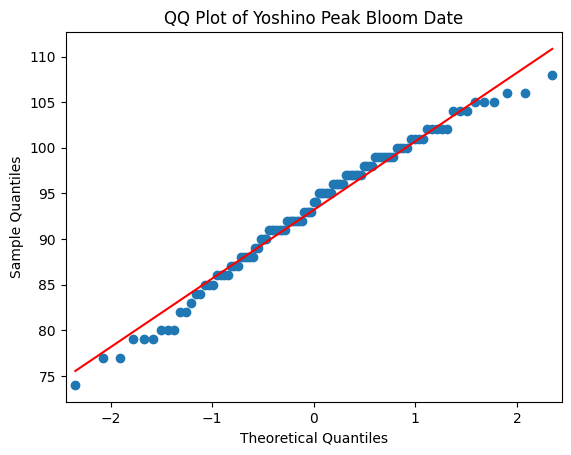

In [6]:
# create a QQ plot to assess the normality of PBD which will help determine which model is most suitable

sm.qqplot(df_PBD['Yoshino peak bloom date'], line='s')
plt.title('QQ Plot of Yoshino Peak Bloom Date')
plt.show()

For accurate predictions, many statistical methods rely on the assumption that datasets follow a normal distribution. The red line in the QQ plot shows what perfectly normal data would look like. Due to slight deviations from normality at the tails where outliers may occur, a Robust Linear Model (RLM) will be used in the Analysis section to reduce the influence of outliers and improve model reliability.

##Analysis
In this section, the relationship between pre-bloom temperatures and the PBD of Yoshino cherry blossoms in Washington D.C. is investigated. The goal of this EDA is to uncover trends, patterns, or correlations that may help explain how climatic factors influence bloom timing.

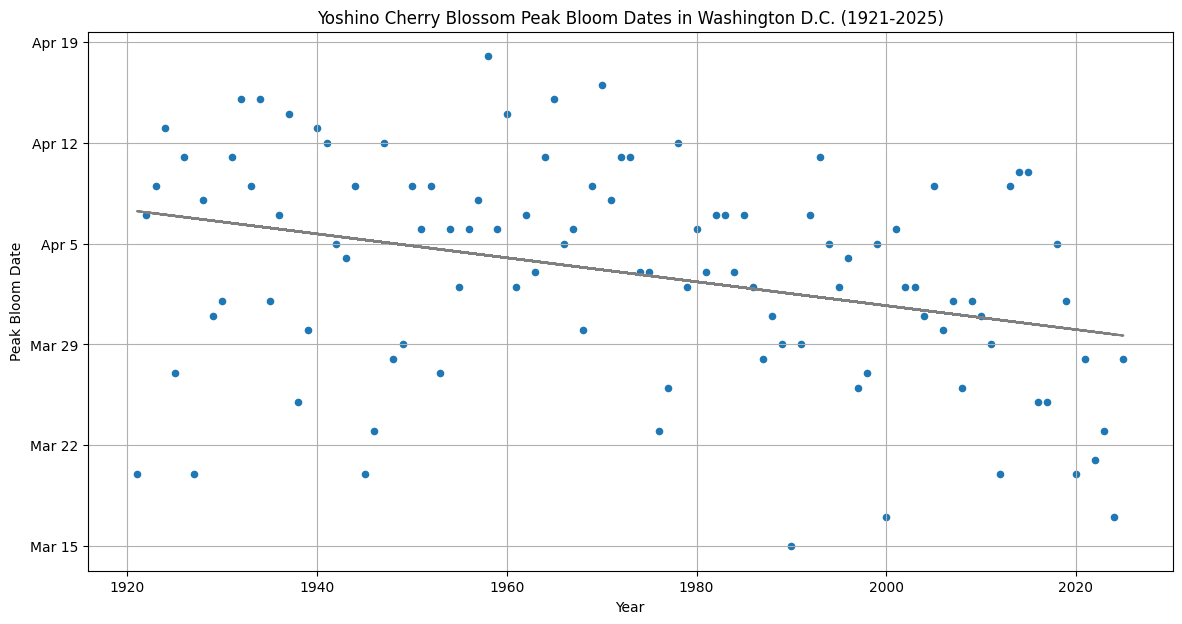

In [7]:
# display PBD over time to identify any trends
# PBD is transformed for readability

def date_num(row):
    if row['month'] == 'March':
        return row['day']
    elif row['month'] == 'April':
        return row['day'] + 31
    else:
        return None

df_PBD['date_num']=df_PBD.apply(date_num, axis=1)
df_PBD=df_PBD.sort_values(by='date_num')

plt.figure(figsize=(14, 7))
plt.scatter(df_PBD['Year'], df_PBD['date_num'], s=20)
plt.title('Yoshino Cherry Blossom Peak Bloom Dates in Washington D.C. (1921-2025)')
plt.xlabel('Year')
plt.ylabel('Peak Bloom Date')

model = LinearRegression()
model.fit(df_PBD[['Year']], df_PBD['date_num'])
df_PBD['trend'] = model.predict(df_PBD[['Year']])

yticks = np.arange(1, 62, 7)
yticklabels= []
for tick in yticks:
  if tick <= 31:
      yticklabels.append(f'Mar {tick}')
  else:
      yticklabels.append(f'Apr {tick-31}')

plt.yticks(yticks, yticklabels)
plt.plot(df_PBD['Year'], df_PBD['trend'], color='gray', label='Linear Trendline')
plt.grid(True)
plt.show()

The above scatterplot displays the annual PBD in Washington D.C. from 1921 to 2025. A slight downward trend suggests that the PBD is occuring earlier than years prior, despite substantial variability from year to year.

In [8]:
# PBD is divided into four (26-27 year) periods: 1921-1946, 1947-1972, 1973-1998, and 1999-2025 to identify average PBD over time

bins=[1920, 1947, 1973, 1999, 2026]
labels=['1921-1946', '1947-1972', '1973-1998', '1999-2025']
df_PBD['period']=pd.cut(df_PBD['Year'], bins=bins, labels=labels, right=False)
PBD_by_period=df_PBD.groupby('period', observed=True)['Yoshino peak bloom date'].mean().round(1)

PBD_by_period.head()

,Yoshino peak bloom date
period,
1921-1946,94.5
1947-1972,97.2
1973-1998,92.2
1999-2025,89.0


The average PBD of the most recent period (1999-2025) falls in March (March 30th), whereas the average PBD for the previous periods occurred in April, indicating that peak bloom dates are occuring earlier in the year compared to prior decades.

According to NPS, the timing of cherry blossom blooms is influenced by weather conditions and temperature. To determine the pre-bloom temperature, average March temperature was used as a key period where warmer temperature accelerates bloom development.

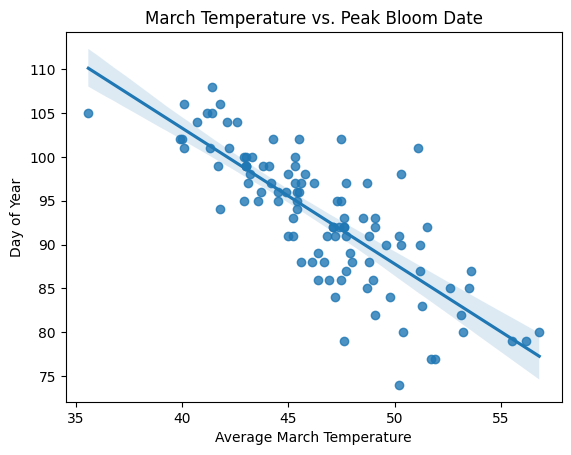

                       Robust linear Model Regression Results                      
Dep. Variable:     Yoshino peak bloom date   No. Observations:                  105
Model:                                 RLM   Df Residuals:                      103
Method:                               IRLS   Df Model:                            1
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Sun, 06 Apr 2025                                         
Time:                             20:04:21                                         
No. Iterations:                         11                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [9]:
# plot average March temperature against PBD for visual comparison

df_PBD['avg_march_temp'] = df_PBD['Year'].map(df_temp.set_index('Year')['Mar'])

sns.regplot(x='avg_march_temp', y='Yoshino peak bloom date', data=df_PBD)
X2=df_PBD['avg_march_temp']
y2=df_PBD['Yoshino peak bloom date']
X2 =sm.add_constant(X2)

model2=RLM(y2,X2, M=sm.robust.norms.HuberT()).fit()
plt.title(f'March Temperature vs. Peak Bloom Date')
plt.xlabel('Average March Temperature')
plt.ylabel('Day of Year')

plt.show()
print(model2.summary())

The RLM shows a statistically significant (p<0.001) negative relationship between average March temperature and PBD. This finding strongly suggests that warmer March temperature corresponds with earlier peak bloom.

The average temperature from March 1st until the Peak Bloom Date (PBD) reflects the overall spring warmth experienced by the cherry blossoms. Warmer averages generally accelerate bud development, potentially leading to an earlier bloom, while cooler temperatures may cause a delay. Monitoring this average reveals how the thermal conditions of early spring influence the timing of the PBD.

In [10]:
# prepare daily temperature data for analysis
# narrow the analysis to 2000-2025 to focus on more recent trends

df_daily['daily_date']=pd.to_datetime(df_daily['date'])
df_daily['avg_temp']=pd.to_numeric(df_daily['avg_temp'], errors='coerce')
df_daily['DOY_daily']=df_daily['daily_date'].dt.dayofyear
df_daily['Year']=df_daily['daily_date'].dt.year
df_daily.drop(columns=['depart','HDD', 'CDD', 'precip', 'new_snow', 'snow_depth'], inplace=True)
df_daily.head()

,date,max_temp,min_temp,avg_temp,daily_date,DOY_daily,Year
0,2000-03-01,64,40,52.0,2000-03-01,61,2000
1,2000-03-02,60,39,49.5,2000-03-02,62,2000
2,2000-03-03,54,35,44.5,2000-03-03,63,2000
3,2000-03-04,58,35,46.5,2000-03-04,64,2000
4,2000-03-05,67,41,54.0,2000-03-05,65,2000


In [11]:
# calculate average temperature from March 1 until PBD for each year 2000-2025

df_PBD_daily=pd.merge(df_daily, df_PBD, on="Year", how="left")
df_avgtemp = df_PBD_daily[df_PBD_daily['DOY_daily'] <= df_PBD_daily['Yoshino peak bloom date']].groupby('Year')['avg_temp'].mean().reset_index()
df_avgtemp.rename(columns={'avg_temp': 'avg_temp_until_PBD'}, inplace=True)
df_avgtemp=df_avgtemp.merge(df_PBD_daily[['Year', 'Yoshino peak bloom date', 'PBD']], on='Year', how='left')
df_avgtemp=df_avgtemp.drop_duplicates()
df_avgtemp.head()

,Year,avg_temp_until_PBD,Yoshino peak bloom date,PBD
0,2000,53.117647,77,2000-03-17
31,2001,44.986486,96,2001-04-06
92,2002,48.090909,92,2002-04-02
153,2003,47.560606,92,2003-04-02
214,2004,48.790323,91,2004-03-31


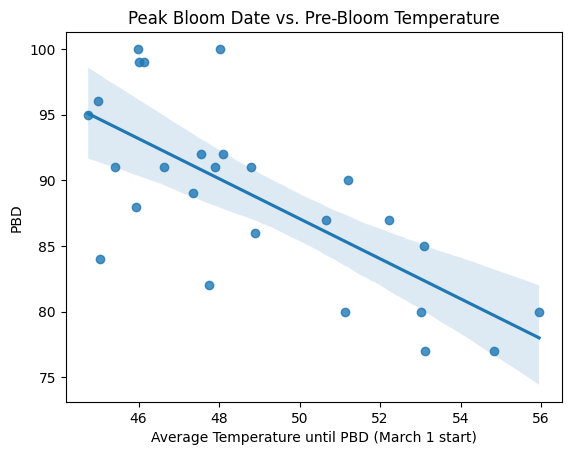

Spearman's correlation coefficient: -0.66
p-value: 0.0003


In [12]:
# plot average temperature from March 1 up until PBD against PBD for visual comparison

sns.regplot(x='avg_temp_until_PBD', y='Yoshino peak bloom date', data=df_avgtemp)

plt.title(f'Peak Bloom Date vs. Pre-Bloom Temperature')
plt.xlabel('Average Temperature until PBD (March 1 start)')
plt.ylabel('PBD')

plt.show()


# since the sample size is small (26), the Spearman test is used to assess the statistical significance of the relationship

from scipy.stats import spearmanr
df_avgtemp=df_avgtemp.sample(26, random_state=42)
correlation, p_value = spearmanr(df_avgtemp['avg_temp_until_PBD'], df_avgtemp['Yoshino peak bloom date'])

print(f"Spearman's correlation coefficient: {correlation:.2f}")
print(f"p-value: {p_value:.4f}")

The Spearman rank correlation coefficient of -0.66 with a p<0.001 indicates a statistically significant and moderately strong negative monotonic relationship between the average temperature leading to PBD with a March 1st start, and the PBD.

#Conclusion
By examining over a century of Washington D.C. Yoshino cherry blossom peak bloom dates from 1921 to 2025, this analysis reveals statistically significant findings that warmer pre-bloom air temperatures are strongly linked to earlier peak bloom dates, demonstrating an ongoing trend towards earlier blooming over the years.

This conclusion assumes that the observed air temperature data reflects the thermal conditions influencing bud development. Future studies aiming to improve bloom predictions should investigate temperature sensitivities across specific bud developmental stages, integrate soil temperature data, and model the combined influence of winter chilling and pre-bloom warmth for a more comprehensive and accurate PBD forecast.

##Sources

* **Peak bloom date data source:**
    * **Source:** National Park Service
    * **Title:** Community Connection: Cherry Blossom Bloom Dates in Washington, D.C.
    * **URL:** [https://www.epa.gov/climate-indicators/cherry-blossoms](https://www.epa.gov/climate-indicators/cherry-blossoms)
    * **Accessed:** March 23, 2025

* **Washington D.C. temperature data source:**
    * **Source:** National Weather Service
    * **Title:** Climate for Washington Area
    * **URL:** [https://www.weather.gov/wrh/Climate?wfo=lwx](https://www.weather.gov/wrh/Climate?wfo=lwx)
    * **Accessed:** March 27, 2025